## 1. Rehape Data for Convolutional Neural Net

Here, we re-shape the data for use in a CNN.  Specifically we peform the following steps:


*   We re-size the image to 128x128 pixels.  Re-sizing will change the accuracy of the net.  In an earlier version of this project, we experimented with 90x90 resolution images, as the CNNs were able to train much faster.  However, we noticed significant accuracy gains that tapered off at around 200.  We have chosen 128x128 pixels as a compromise between accuracy and speed (enabling us to train deeper CNNs in a shorter amount of time). 
*   We re-code the 120-level y factor variable into a one-hot coded array.
* We convert the X and Y data into a numpy array and normalize the RGB channel by dividing by 255.  Normalizing in this way is not dissimilar to batch normalization which reduces the amount of covariance shift during training. 
* Lastly, we divide the overall training set into a 70-30 split of a training and validation set. 



In [0]:
# from sklearn.model_selection import train_test_split
# #Create training dataframe and a validation dataframe based on splits
# train_df_split, validation_df_split = train_test_split(train_df, test_size=0.3)

In [0]:
# display(train_df_split.shape)
# display(validation_df_split.shape)

(8400, 7)

(3600, 7)

In [0]:
# train_df.head()

,File,Annotation,Breed,Label,Height,Width,bounding_box
0,n02085620-Chihuahua/n02085620_5927.jpg,n02085620-Chihuahua/n02085620_5927,Chihuahua,1,300,360,"[30.0, 14.0, 206.0, 284.0]"
1,n02085620-Chihuahua/n02085620_4441.jpg,n02085620-Chihuahua/n02085620_4441,Chihuahua,1,500,375,"[107.0, 110.0, 189.0, 291.0]"
2,n02085620-Chihuahua/n02085620_1502.jpg,n02085620-Chihuahua/n02085620_1502,Chihuahua,1,333,500,"[51.0, 13.0, 367.0, 318.0]"
3,n02085620-Chihuahua/n02085620_1916.jpg,n02085620-Chihuahua/n02085620_1916,Chihuahua,1,495,500,"[8.0, 7.0, 448.0, 390.0]"
4,n02085620-Chihuahua/n02085620_13151.jpg,n02085620-Chihuahua/n02085620_13151,Chihuahua,1,336,500,"[176.0, 29.0, 203.0, 304.0]"


In [0]:
# Creates a set of training dummies
train_dummies = pd.get_dummies(train_df.Label)
test_dummies = pd.get_dummies(test_df.Label)

# Converts above to a numpy array
train_labels_one_hot = np.asarray(train_dummies)

In [0]:
%time


# If we plan on using fully-connected and CNN layers, we need to resize all images
X_train = []
y_train = []

# Set pixel dimensions to 128x128
# We can experiment with other dimensions later
# But Google colab dies with larger dimensions
im_size = 128

# Iterate over all values, resize images, append appropriate y values
for index, value in tqdm(train_df.iterrows()):
  
    #we use cv2 instead of imageio because resizing is faster within cv2
    img = cv2.imread("Images/" + train_df.iloc[index].File)
    
    #normalize the image data
    #img = img.astype('float32') / 255.
    
    #convert to the correct RGB channels if reading in via cv2
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    X_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(train_labels_one_hot[index])

12it [00:00, 119.18it/s]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


12000it [00:47, 254.35it/s]


In [0]:
# We divide training data by 255 to normalize the image data
#https://stackoverflow.com/questions/20486700/why-we-always-divide-rgb-values-by-255

X_train = np.array(X_train, np.float32) / 255.
y_train = np.array(y_train, np.uint8)

# The X data now consists of 12,000 images 
# that are 128 pixels by 128 pixels, and 3 channels
display(X_train.shape)

# The y data consists of 12,000 images of 120 distinct breeds
display(y_train.shape)

# Save this for comparison with cropped images later
X_train_norm = X_train

(12000, 128, 128, 3)

(12000, 120)

In [0]:
from sklearn.model_selection import train_test_split

#Now we create the validation set by sampling from the training set 30% of values
X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                y_train, 
                                                                test_size=0.3, 
                                                                random_state=42)

## 2. Baseline Model - Fully Connected Neural Nets

Now, we get into the good stuff.  After doing exploratory data analysis, it was clear to us that the a decent baseline performance model would be achieved with a fully-connected network (no convolutional layers).  We explored other possible baseline models such as an SVM model with an RGB kernel, or using a logistic regression or K-nearest neighbors approach on SIFT and Daisy descriptors, but since we did not cover these models in class, we decided to stick with an approach we were familiar with.  

In any case, the above models have actually performed quite well on this task.  For example, an SVM model with linear kernels on this task can achieve up to 40% accuracy in some cases, so we felt this would be a more approach baseline. 

In [0]:
# Further reshape x data for fully connected neural net
def squish_square(x):
    x_shp=x.reshape(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
    return x_shp

In [0]:
# Second round of pre-processing for train and validation
X_train_shp=squish_square(X_train)
print('New x_train shape: ', X_train_shp.shape)
X_validation_shp=squish_square(X_validation)
print('New x_val shape: ', X_validation_shp.shape)

New x_train shape:  (8400, 49152)
New x_val shape:  (3600, 49152)


In [0]:
from keras.models import Sequential 
from keras.layers import Dense

# Model
H = 100 # number of nodes in each hidden layer
n_hidden_layers = 3
input_dim = X_train_shp.shape[1:]
output_dim =(y_train.shape[1])
print('Number of nodes per hidden layer: ', H)
print('Number of hidden layers: ', n_hidden_layers)
print('input shape: ', input_dim)
print('output shape: ', output_dim)

model = Sequential() # create sequential multi-layer perceptron

# layer 0
model.add(Dense(H, input_shape=input_dim, 
            activation='relu')) 

# Add hidden layers
for i in range(n_hidden_layers-1):
    model.add(Dense(H, activation='relu')) 
# Output layer
model.add(Dense(output_dim, activation='sigmoid', ))

Number of nodes per hidden layer:  100
Number of hidden layers:  3
input shape:  (49152,)
output shape:  120


In [0]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               4915300   
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 120)               12120     
Total params: 4,947,620
Trainable params: 4,947,620
Non-trainable params: 0
_________________________________________________________________


In [0]:
# fit the model
epochs=30
fcn0=model.fit(X_train_shp, y_train, 
          epochs=epochs, 
          validation_data=(X_validation_shp, y_validation), 
          verbose=1) #callbacks = callbacks_list

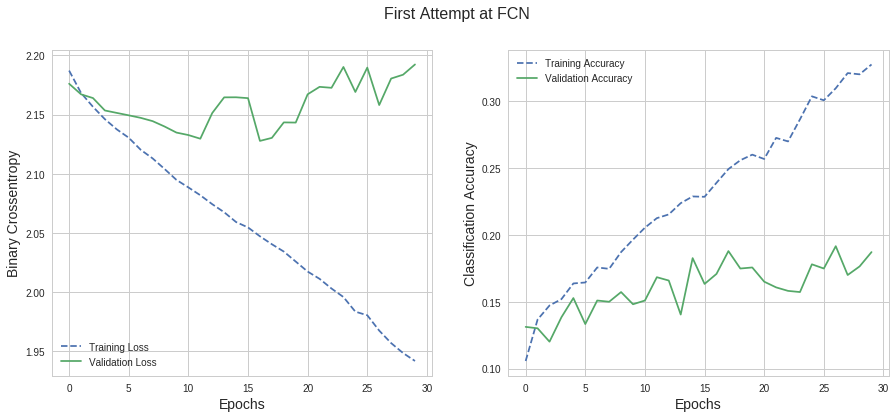

In [0]:
#Plot loss and accuracy to check for overfitting
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(np.sqrt(fcn0.history['loss']), '--', label='Training Loss')
ax[0].plot(np.sqrt(fcn0.history['val_loss']), label='Validation Loss')
ax[0].set_ylabel('Binary Crossentropy', fontsize=14)

ax[1].plot(np.sqrt(fcn0.history['acc']), '--', label='Training Accuracy')
ax[1].plot(np.sqrt(fcn0.history['val_acc']), label='Validation Accuracy')
ax[1].set_ylabel('Classification Accuracy', fontsize=14)

for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel('Epochs', fontsize=14);

fig.suptitle('First Attempt at FCN', fontsize=16);

In [0]:
print('Validation accuracy at final epoch: ', fcn0.history['val_acc'][-1])
print('Best validation accuracy: ', np.array(fcn0.history['val_acc']).max())

Validation accuracy at final epoch:  0.035
Best validation accuracy:  0.03666666666666667


As a base model, we created a fully-connected neural network similar to that implemented in homework 9 for number classification. Guessing 3 layers and 100 nodes per layer as hyperparameters and training for 30 epochs, we acheived a 3.5% validation accuracy on our first attempt.

In [0]:
def make_reg_NN(x=X_train_shp, y=y_train, H=100, n_hidden_layers = 3, \
                x_val=X_validation_shp, y_val=y_validation, \
                eps=40, verb=0):

    input_dim = X_train_shp.shape[1:]
    output_dim =(y_train.shape[1])
    print('Number of nodes per hidden layer: ', H)
    print('Number of hidden layers: ', n_hidden_layers)
    print('input shape: ', input_dim)
    print('output shape: ', output_dim)

    model = Sequential() # create sequential multi-layer perceptron

    #layer 0
    model.add(Dense(H, input_shape=input_dim, 
                activation='relu')) 

    # Add hidden layers
    for i in range(n_hidden_layers-1):
        model.add(Dense(H, activation='relu')) 
        
    # Output layer
    model.add(Dense(output_dim, activation='sigmoid', ))
    
    # compile the model 
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    print(model.summary())
    
    # fit the model
    fitmod=model.fit(x, y, 
          epochs=epochs, 
          validation_data=(x_val, y_val), 
          verbose=verb)
    
    # print validation accuracy on last epoch
    print('Validation accuracy: :', fitmod.history['val_acc'][-1])
    
    return model, fitmod

In [0]:
# Create a dictionary to store models
fcn_models = {}
fcn_models['100node_3layer']=fcn0

# Create a dictionary to store val records for later comparison
fcn_hist = {}
fcn_hist['100node_3layer']=fcn0.history

In [0]:
fcn_models['150node_3layer'], fcn_hist['150node_3layer']=\
                        make_reg_NN(H=150, n_hidden_layers = 3)

Number of nodes per hidden layer:  150
Number of hidden layers:  3
input shape:  (49152,)
output shape:  120
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 150)               7372950   
_________________________________________________________________
dense_14 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_15 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_16 (Dense)             (None, 120)               18120     
Total params: 7,436,370
Trainable params: 7,436,370
Non-trainable params: 0
_________________________________________________________________
None
Validation accuracy: : 0.025


In [0]:
fcn_models['100node_3layer'], fcn_hist['100node_3layer']=\
                        make_reg_NN(H=100, n_hidden_layers = 3)

Number of nodes per hidden layer:  100
Number of hidden layers:  3
input shape:  (49152,)
output shape:  120
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               4915300   
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 120)               12120     
Total params: 4,947,620
Trainable params: 4,947,620
Non-trainable params: 0
_________________________________________________________________
None
Validation accuracy: : 0.030833333333333334


In [0]:
fcn_models['100node_5layer'], fcn_hist['100node_5layer']=\
                        make_reg_NN(H=100, n_hidden_layers = 5)

Number of nodes per hidden layer:  100
Number of hidden layers:  5
input shape:  (49152,)
output shape:  120
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               4915300   
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_28 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_29 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_30 (Dense)             (None, 120)               12120     
Total params: 4,967,820
Trainable

**Comment:**

Keeping with basic fully-connected network strategy, we increased the number of epochs from 30 and 40 and tried adjusting both the number of layers and number of nodes per layer. These variations yielded even lower validation performance than our original FCN, with validation accuracies ranging from 2.5-3.1%.  Thus, we will set a 3% accuracy as our baseline to beat.  

This is not far from [others projects](http://cs231n.stanford.edu/reports/2015/pdfs/fcdh_FinalReport.pdf) which were only able to achieve 9.5% in 2015.  

## 3. Custom-Architecture CNN (With Dropout)

Now, we test our first CNN, which utilizes an architecture that is not dissimilar to the one used in the VGG16 network which, at the time, destroyed the competition on ImageNet classification.  

This architecture specifically utilizes convolutional layers followed by max pooling layers followed by a drop out layer.  This sequence repeats itself four times before being followed by a Global Average Pooling layer, and finally a Dense layer to generate predictions into 120 classes.  

The convolutional layers begin by generating 16 filters (e.g. feature maps) and progressively double the number of filters in each successive layer.  The intuition behind doubling the filters at each step is that each convolutional layer picks up on successively more abstract and diffuse characteristics of the original image.  So, whereas the first convolutional layer may pick up on edges and lines, the second layer may pick up on textures or multiple touching edges, and so on.  

The following image taken from Stanford's CS 231N course taught by Andrej Karpathy and Justin Johnson helps to clarify this intuition:


![alt text](
https://i.stack.imgur.com/5yGWY.png)

Here, we see successive convolutional layers in a CNN, and notice that each layer picks up on progressively more complex features -- thus the need to increase the feature map to allow greater exploration of these complexities. 

We also begin with a kernel size of 4 and gradually decrease this to 2 with each convolutional layer, until eventually settling on a kernel size of 3 for the final layer.  We do this for a couple of reasons:

1. Larger kernels at earlier layers means computational time is faster and memory usage is smaller.  However, the trade-off is a loss of detail as the size of the kernel determines how many neurons will be outputted into the next layer.  A kernel size of 1 implies that the number of neurons entering a layer will be the same as the amount exiting a layer.   

2. We chose to accept this loss a lot of detail early on because it helps make the model robust to overfitting, and because earlier convolutional layers are picking up on simpler features (see above), so it doesn't hurt to have larger kernels.  

For a better intuition of what exactly is being manipulated when we determine the kernel size, we have found the following GIF particularly instructive, from this immensely useful [website](http://machinelearninguru.com/computer_vision/basics/convolution/convolution_layer.html):

![alt text](https://i.stack.imgur.com/9OZKF.gif).

Above we see that the kernel size is set to 3x3, which we can think of as a 'spotlight' that convolves around the image.  (This particular image is padded with one pixel in every dimension so that the corners can be included in the calculation.) . As the spotlight moves around the image, each 3x3 matrix is being multiplied (dot product) by a 'kernel matrix' which is simply some pre-set matrix that generates some useful features in the output matrix.  

Different kernel matrices yield different output matrices.  The below graphic taken from [this site](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) is helpful in understanding the effect of different kernel matrices on output. 

![alt text](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-05-at-11-03-00-pm.png?w=342&h=562)

We add drop-out layers in between each stack in order to minimize overfitting.  Drop-out can be thought of as a form of regularization.  We increase the amount of dropout at each 'stack' because, as we move through a network, over-fitting is more likely.  It's particularly important to include drop out layers in the fully-connected networks at the end.

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D

#Model based on intuition from VGG network with following several differences:
#Added progressively increasing drop-out layers from each CNN layer
#Kernel size progressively decreases and then goes back to '3'
#Filter size doubles each layer

model = Sequential()
model.add(BatchNormalization(input_shape=(128, 128, 3)))
model.add(Conv2D(filters=16, kernel_size=4, kernel_initializer='he_normal', activation='relu'))   
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))   
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Conv2D(filters=64, kernel_size=2, kernel_initializer='he_normal', activation='relu'))   
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))   
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(GlobalAveragePooling2D())

# Fully Connected Layer
model.add(Dense(120, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 16)      784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 62, 62, 16)        64        
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
__________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
epochs = 25

#callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='weights_custom_model_best.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_acc')]
model.fit(X_train, y_train, 
          epochs=epochs, 
          validation_data=(X_validation, y_validation), 
          verbose=1,
          callbacks = callbacks_list)

Train on 8400 samples, validate on 3600 samples
Epoch 1/25
8400/8400 [==============================] - 12s 1ms/step - loss: 3.6639 - acc: 0.1486 - val_loss: 4.1683 - val_acc: 0.0767

Epoch 00001: val_acc improved from -inf to 0.07667, saving model to weights_custom_model_best.hdf5
Epoch 2/25
8400/8400 [==============================] - 12s 1ms/step - loss: 3.5881 - acc: 0.1637 - val_loss: 4.1243 - val_acc: 0.0836

Epoch 00002: val_acc improved from 0.07667 to 0.08361, saving model to weights_custom_model_best.hdf5
Epoch 3/25
8400/8400 [==============================] - 12s 1ms/step - loss: 3.5194 - acc: 0.1699 - val_loss: 3.9482 - val_acc: 0.1042

Epoch 00003: val_acc improved from 0.08361 to 0.10417, saving model to weights_custom_model_best.hdf5
Epoch 4/25
8400/8400 [==============================] - 12s 1ms/step - loss: 3.4660 - acc: 0.1835 - val_loss: 4.0082 - val_acc: 0.1006

Epoch 00004: val_acc did not improve from 0.10417
Epoch 5/25
8400/8400 [==============================] -

In [0]:
from google.colab import files
files.download('weights_custom_model_best.hdf5')

**Comments**:

*   We see that, impressively, we achieve a 15% accuracy on the validation set with a completely hand-crafted architecture.  A lot of the technique came from emulating networks which already perform well on ImageNet-like problems, but it is still impressive that a relatively naive model with only 25 epochs is able to achieve such high accuracy compared to baseline. 



## 4. Visualize Intermediate Layers of Custom CNN

It is often useful, or at least interesting, to see what is being visualized at each layer in our CNN.  We want, as much as possible, to ensure that the CNN is not being treated as a black box, so it is important to understand and display activations at each layer. 

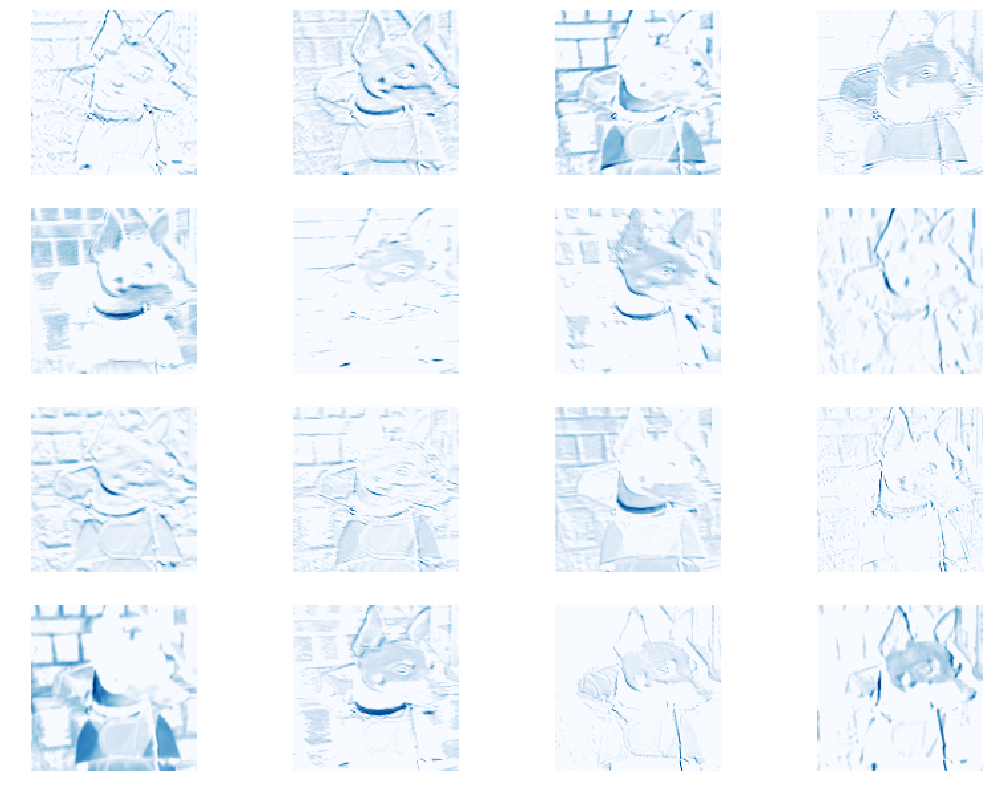

In [0]:
#Visualization code adapted from: https://www.codeastar.com/visualize-convolutional-neural-network/

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[15].reshape(1,128,128,-1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*4.5,col_size*3.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap = 'Blues')
            ax[row][col].set_axis_off()
            activation_index += 1
            
display_activation(activations, 4, 4, 1)

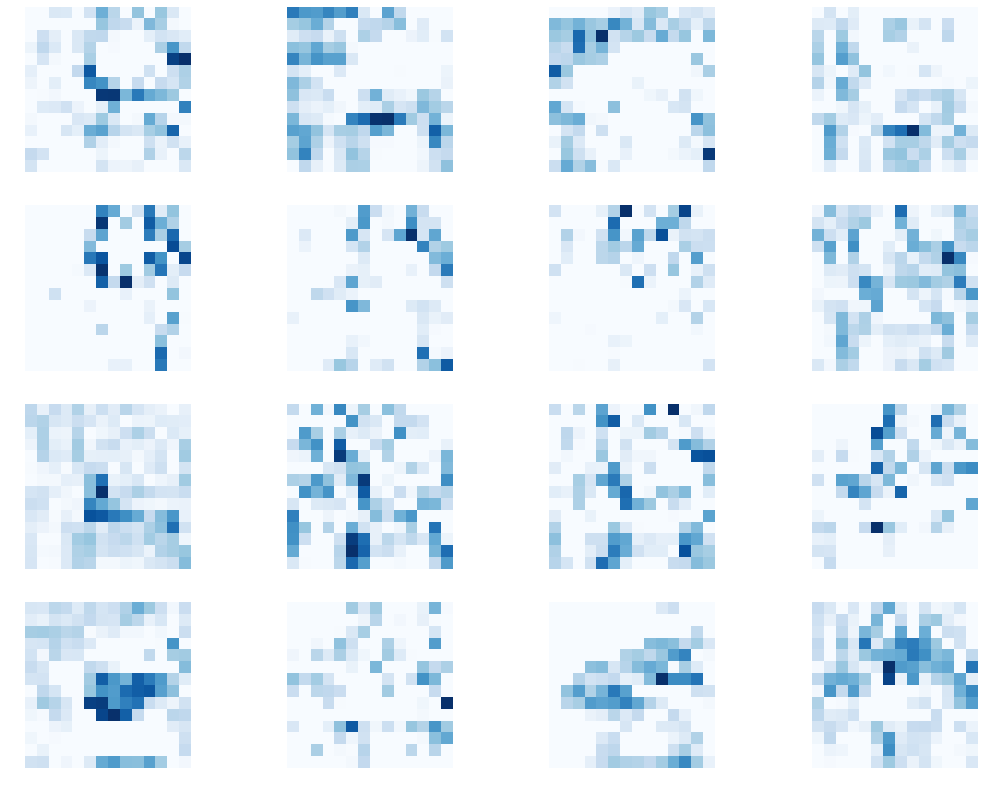

In [0]:
display_activation(activations, 4, 4, 12)

**Comments:**

* We see that the first convolutional layer picks up on edges, generating images that are remarkably similar to a Sobel edge detector that was used in the EDA.
* By the time we get to the 10th layer, however, the resulting image is highly pixelated (due to max-pooling), leaving behind highly abstract and diffuse representations of the original image.  It's unclear whether these layers are picking up on higher-order features, or are just generating noise.  I imagine if we were to visualize the layers resulting from deeper CNN's like ResNet or Inception, we would see more interesting visualizations. 


## 5. Custom Architecture CNN (No Dropout Layers)


We were a little concerned that adding such liberal amounts of drop-out layers in the above architecture was damaging the ability of our CNN to learn from such a sparse supply of training images.  We re-run the same analysis with no drop-out layers and compare each model looking only at the 10th epoch.  

In [0]:
#Model based on intuition from VGG network with following several differences:
#Added progressively increasing drop-out layers from each CNN layer
#Kernel size progressively decreases and then goes back to '3'
#Filter size doubles each layer

model = Sequential()
model.add(BatchNormalization(input_shape=(im_size, im_size, 3)))
model.add(Conv2D(filters=16, kernel_size=4, kernel_initializer='he_normal', activation='relu'))   
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))   
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=2, kernel_initializer='he_normal', activation='relu'))   
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))   
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

# Fully Connected Layer
model.add(Dense(120, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_228 (Bat (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 125, 125, 16)      784       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
batch_normalization_229 (Bat (None, 62, 62, 16)        64        
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_230 (Bat (None, 30, 30, 32)        128       
__________

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

epochs = 10

callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='weights_custom_model_no_dropout_best.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_acc')]
history = model.fit(X_train, y_train, 
          epochs=epochs, 
          validation_data=(X_validation, y_validation), 
          verbose=1,
          callbacks = callbacks_list)

Train on 8400 samples, validate on 3600 samples
Epoch 1/10
8400/8400 [==============================] - 25s 3ms/step - loss: 4.6369 - acc: 0.0294 - val_loss: 4.4880 - val_acc: 0.0386

Epoch 00001: val_acc improved from -inf to 0.03861, saving model to weights_custom_model_no_dropout_best.hdf5
Epoch 2/10
8400/8400 [==============================] - 12s 1ms/step - loss: 4.3752 - acc: 0.0558 - val_loss: 4.3919 - val_acc: 0.0478

Epoch 00002: val_acc improved from 0.03861 to 0.04778, saving model to weights_custom_model_no_dropout_best.hdf5
Epoch 3/10
8400/8400 [==============================] - 12s 1ms/step - loss: 4.2041 - acc: 0.0780 - val_loss: 4.2816 - val_acc: 0.0581

Epoch 00003: val_acc improved from 0.04778 to 0.05806, saving model to weights_custom_model_no_dropout_best.hdf5
Epoch 4/10
8400/8400 [==============================] - 12s 1ms/step - loss: 4.0548 - acc: 0.0985 - val_loss: 4.1124 - val_acc: 0.0794

Epoch 00004: val_acc improved from 0.05806 to 0.07944, saving model to w

In [0]:
from google.colab import files
files.download('weights_custom_model_no_dropout_best.hdf5')

**Comments**:

Thankfully, we see that the model with drop-out outperforms the model without drop-out, suggesting that, at least with these hand-crafted models, drop out is potentially useful to avoid overfitting on sparse training sets. Specifically, the model without drop-out has a validation accuracy of 13.25% whereas the model with  drop-out has a validation accuracy of 13.92% after the 10th epoch. 

## 6. Fine-Tuning VGG19

Now, we bring out the big guns.  We use the most recent version of the VGG19 CNN from the Keras package.  VGG19 is a very popular machine learning architecture that has historically performed well on ImageNet tasks.  Its architecture is very similar to the custom one described above.  Below, we 'fine-tune' the VGG model, which is to say that we preserve the existing pre-trained weights of the VGG network, and simply add a final Dense layer at the end with a softmax classifier.  This Dense layer translate the final activations into a [0, 1] score, which is synonymous with a probability score for each of the 120 classes. The class with the highest probability score is selected as the prediction. 

We use categorical cross entropy as the loss function and use the 'adam' optimizer in each of these models.  

In [0]:
# See tutorial on fine-tuning here: https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
vgg_conv = VGG19(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))

# Set all the layers in the main vgg network to untrainable
for layer in vgg_conv.layers:
    layer.trainable = False
    
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add Flatten layer and Dense layer
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='softmax'))
 
# Compile the model using categorical cross_entropy
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Stop if validation accuracy not improving 
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='weights_vgg19_best.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_acc')]

# Show a summary of the model. Check the number of trainable parameters
model.summary()

80142336/80134624 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 20,270,264
Trainable params: 245,880
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
epochs = 10
model.fit(X_train, y_train, epochs=epochs, 
          validation_data=(X_validation, y_validation), 
          callbacks = callbacks_list,
          verbose=1)

Train on 8400 samples, validate on 3600 samples
Epoch 1/10
8400/8400 [==============================] - 33s 4ms/step - loss: 4.5699 - acc: 0.0498 - val_loss: 4.2280 - val_acc: 0.0947
Epoch 2/10
8400/8400 [==============================] - 29s 4ms/step - loss: 3.5959 - acc: 0.1951 - val_loss: 4.0599 - val_acc: 0.1081
Epoch 3/10
8400/8400 [==============================] - 30s 4ms/step - loss: 3.1034 - acc: 0.2957 - val_loss: 3.9882 - val_acc: 0.1239
Epoch 4/10
8400/8400 [==============================] - 30s 4ms/step - loss: 2.7509 - acc: 0.3751 - val_loss: 3.9748 - val_acc: 0.1250
Epoch 5/10
8400/8400 [==============================] - 30s 4ms/step - loss: 2.4665 - acc: 0.4426 - val_loss: 3.9802 - val_acc: 0.1303
Epoch 6/10
8400/8400 [==============================] - 30s 4ms/step - loss: 2.2286 - acc: 0.5071 - val_loss: 3.9585 - val_acc: 0.1342
Epoch 7/10
8400/8400 [==============================] - 30s 4ms/step - loss: 2.0239 - acc: 0.5660 - val_loss: 3.9769 - val_acc: 0.1303
Epoch 8

In [0]:
files.download('weights_vgg19_best.hdf5')

We see that the fine-tuned VGG19 network achieves impressive performance on the training set (69.70%) but this does not translate to the validation set, suggesting that our CovNet is overfitting.  To correct for this issue, we implement data augmentation and drop out layers on the VGG19 architecture. 

## 7. Fine-Tuning VGG19 with Data Augmentation and Drop-Out Layers

Next, we utilize an extremely important strategy in machine learning: Data Augmentation.  Data Augmentation is a strategy to dynamically increase the size of one's training set by manipulating existing training images through flips, rotations, and translations.


![alt text](https://cdn-images-1.medium.com/max/800/1*C8hNiOqur4OJyEZmC7OnzQ.png)

Strictly speaking, images in the training set do not need to be novel in order for the CNN to learn from them.  The CNN does not have a understanding of the underlying concept being represented in an image, and thus can extract information from minor perturbations in existing images.   

Thus, we augment our dataset with a number of image transformations (such as rotations, zooms, horizontal flips, shearing, and so on).  One of the benefits of image augmentation is that CNN's learn to be invariant to  **translation, viewpoint, size, and illumination.** . In the absence of this invariance, a CNN may pick up on irrelevant lower-level features of an image that are useful for distinguishing that image from others in the training set, but are not generalizable.  For example, it may notice that every Border Collie in the training set is facing to the right, and may use that idiosyncracy to correctly identify Border Collies.  However, if it stumbles upon a Border Collie in the test set facing left, it would misclassify the image.  Image Augmentation helps to prevent this kind of overfitting. 

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Let's go wild with data augmentation. 
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

# You don't do data augmentation on validation
validation_datagen = ImageDataGenerator()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_datagen.fit(X_train)
validation_datagen.fit(X_validation)

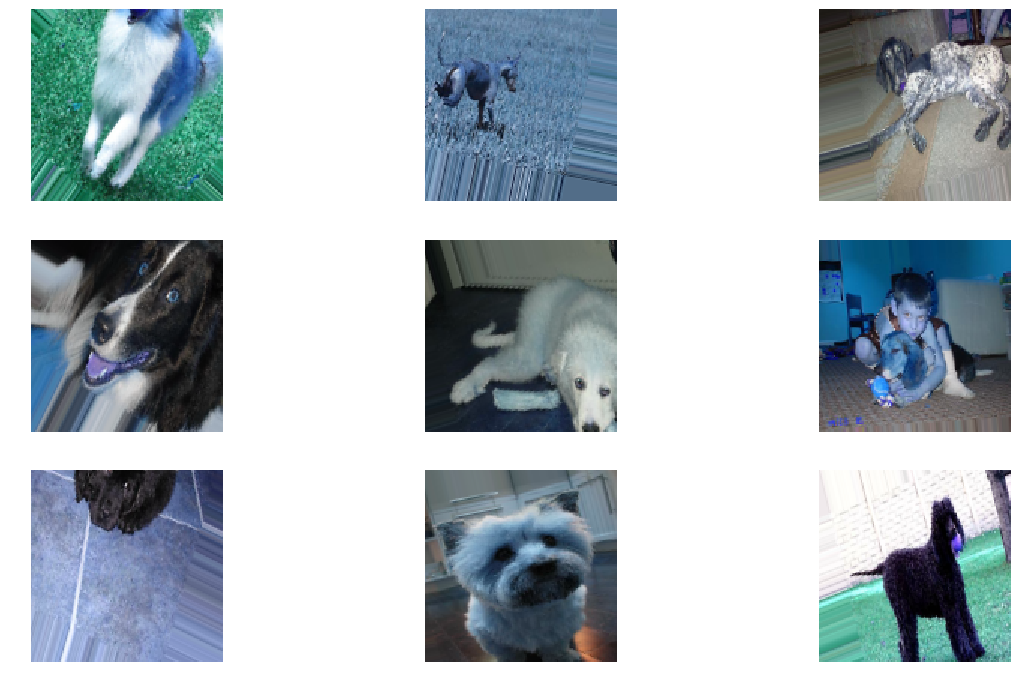

In [0]:
#Let's visualize these augmentations
fig, axes = plt.subplots(4, 3, figsize=(20, 12))
ax = axes.flatten()
i=0
for img_batch in train_datagen.flow(X_train, batch_size=9):
    for img in img_batch:
        plt.subplot(330 + 1 + i)
        plt.imshow(img)
        plt.axis('off')
        i=i+1    
    if i >= 9:
        break   

**Comments:**

Above, we see a few examples generated from our augmentation procedures.  Images are rotated, sheared, and translated.  In a few of these cases (e.g.  row 3 column 1), the actual dog represents a small part of the image.  In column 1 row 1, part of the dog's head is cut-off due to rotation.  Unfortunately, this is a risk with image augmentation, but we hope that the advantages will outweigh the disadvantages.  

Perhaps a better approach would be to first crop the images to only include the dog, and later apply transformations (to minimize the risk of part of the dog being cut-off).  We thus make the following prediction: image augmentation will yield substantially higher returns after cropping than without. 

In [0]:
#VGG model with drop-out layers

vgg_conv = VGG19(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))

# Set all the layers in the main vgg network to untrainable
for layer in vgg_conv.layers:
    layer.trainable = False
    
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add Flatten layer and Dense layer
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))

# Add Fully - Connected Layers with Drop-Out
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Prediction Layer
model.add(layers.Dense(120, activation='softmax'))
 
# Compile the model using categorical cross_entropy
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Stop if validation accuracy not improving 
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='weights_vgg19_dropout_best.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_acc')]

# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_3 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              4196352   
__________

In [0]:
# fits the model on batches with real-time data augmentation:
epochs = 10
batch_size = 32

model.fit_generator(train_datagen.flow(X_train, y_train),
                    epochs=epochs,
                    steps_per_epoch= X_train.shape[0] / batch_size,
                    validation_steps=X_validation.shape[0] / batch_size,
                    validation_data=validation_datagen.flow(X_validation, y_validation),
                    callbacks = callbacks_list)

Epoch 1/10
263/262 [==============================] - 36s 137ms/step - loss: 6.0805 - acc: 0.0177 - val_loss: 4.8945 - val_acc: 0.0464
Epoch 2/10
263/262 [==============================] - 34s 131ms/step - loss: 5.4997 - acc: 0.0328 - val_loss: 4.6251 - val_acc: 0.0644
Epoch 3/10
263/262 [==============================] - 35s 134ms/step - loss: 5.2161 - acc: 0.0413 - val_loss: 4.5125 - val_acc: 0.0750
Epoch 4/10
263/262 [==============================] - 35s 132ms/step - loss: 5.0059 - acc: 0.0465 - val_loss: 4.3711 - val_acc: 0.0806
Epoch 5/10
263/262 [==============================] - 34s 130ms/step - loss: 4.8491 - acc: 0.0583 - val_loss: 4.3210 - val_acc: 0.0781
Epoch 6/10
263/262 [==============================] - 34s 130ms/step - loss: 4.7255 - acc: 0.0619 - val_loss: 4.3299 - val_acc: 0.0853
Epoch 7/10
263/262 [==============================] - 34s 129ms/step - loss: 4.6248 - acc: 0.0661 - val_loss: 4.2022 - val_acc: 0.1000
Epoch 8/10
263/262 [==============================] - 3

In [0]:
files.download('weights_vgg19_dropout_best.hdf5')

**Comments:**

We see that our VGG network without image augmentation outperformed out network with augmentation.  Furthermore, our custom neural net with no pre-trained weights outperformed a fine-tuned VGG network!  

We suspect that image augmentation was unsuccessful in this case due to the point identified above (that aggressive augmentation runs the risk of cutting off crucial features of the dog).  

##15. Inception v3 Neural Net

Next, we text the latest version of Inception available via Keras (There is technically an Inceptionv4 available through PyTorch, but we didn't want to venture off into the wilds of the internet for marginal gains on this task). 

Inception v3 is based on Google's novel GoogLeNet architecture which achieved state-of-the-art performance on art recognition in 2014. Inception utilizes a new concept known as "inception modules", the inspiration for which comes from the fact that a researcher has multiple decision points when crafting each convolutional layer, perhaps the most important of which is what kernel size to use when convolving.   Do you implement a 1x1, 3x3, or 5x5 kernel?  Or some combination of these, perhaps?  If you'll recall, we try a mix of these kernels in our hand-crafted CNN above, but we did not have a particularly meaningful decision rule to justify these deviations from the standard 3x3 model.  

Inception modules resolves this problem by essentially doing every combination of these filters in parallel and concatenating the feature maps.  There are a few clever optimizations involving 1x1 layers prior to 3x3 or the 5x5 layer (see below Image [[lmage Source](https://arxiv.org/abs/1409.4842)] for details), but the idea is fairly intuitive. 

![alt text](https://hackathonprojects.files.wordpress.com/2016/09/inception_implement.png?w=649&h=337)   



In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD, RMSprop, Adam

inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))

# Set all the layers in the main vgg network to untrainable
for layer in inception_v3.layers:
    layer.trainable = False
    
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(inception_v3)
 
# Add Flatten layer and Dense layer
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))

# Add Fully - Connected Layers with Drop-Out
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Prediction Layer
model.add(layers.Dense(120, activation='softmax'))
 
# Compile the model using categorical cross_entropy
# Add learning rate and weight decay 
model.compile(loss='categorical_crossentropy', 
              #optimizer=Adam(lr=1e-4, decay=1e-5), 
              optimizer = "Adam",
              metrics=['accuracy'])

# Stop if validation accuracy not improving 
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='weights_inceptionv3_dropout_best.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_acc')]

# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
batch_normalization_191 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
__________

In [0]:
epochs = 10
model.fit(X_train, y_train, epochs=epochs, 
          validation_data=(X_validation, y_validation), 
          callbacks = callbacks_list,
          verbose=1)

Train on 5880 samples, validate on 2520 samples
Epoch 1/10
5880/5880 [==============================] - 36s 6ms/step - loss: 5.8112 - acc: 0.0209 - val_loss: 14.2474 - val_acc: 0.0369

Epoch 00001: val_acc improved from -inf to 0.03690, saving model to weights_inceptionv3_dropout_best.hdf5
Epoch 2/10
5880/5880 [==============================] - 25s 4ms/step - loss: 5.1376 - acc: 0.0583 - val_loss: 13.5310 - val_acc: 0.0516

Epoch 00002: val_acc improved from 0.03690 to 0.05159, saving model to weights_inceptionv3_dropout_best.hdf5
Epoch 3/10
5880/5880 [==============================] - 26s 4ms/step - loss: 4.8007 - acc: 0.0888 - val_loss: 14.1351 - val_acc: 0.0500

Epoch 00003: val_acc did not improve from 0.05159
Epoch 4/10
5880/5880 [==============================] - 25s 4ms/step - loss: 4.5557 - acc: 0.1235 - val_loss: 13.2935 - val_acc: 0.0817

Epoch 00004: val_acc improved from 0.05159 to 0.08175, saving model to weights_inceptionv3_dropout_best.hdf5
Epoch 5/10
5880/5880 [========

In [0]:
files.download('weights_inceptionv3_dropout_best.hdf5')


**Comment:**

We see that our model achieved a disappointing 10% accuracy on the validation set. We will try a model that regularly outperforms Inception (XCeption).  

## 8. XCeption Model

Having trained and tested multiple models on the data, we now move to the XCeption V1 model, by Francois Chollet, available with weights pre-trained on ImageNet. According to Keras documentation this model gets to a top-1 validation accuracy of 0.790 and a top-5 validation accuracy of 0.945 on ImageNet, and is therefore a great candidate for dog breed classification. It is a deep convolutional neural network architecture inspired by Inception (tested previously in this report), where Inception modules have been replaced with depthwise separable convolutions. The XCeption architecture slightly outperforms Inception V3 on the ImageNet dataset (which Inception V3 was designed for), and significantly outperforms Inception V3 on a larger image classification dataset comprising 350 million images and 17,000 classes. Since the Xception architecture has the same number of parameters as Inception V3, the performance gains are not due to increased capacity but rather to a more efficient use of model parameters. In the following the XCeption V1 model will be tested. First with augmented image data, then subsequently with data augmentation and image cropping.

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications import xception

from keras.optimizers import SGD, RMSprop, Adam

xception = xception.Xception(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))

# Set all the layers in the main vgg network to untrainable
for layer in xception.layers:
    layer.trainable = False
    
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(xception)
 
# Add Flatten layer and Dense layer
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))

# Add Fully - Connected Layers with Drop-Out
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Prediction Layer
model.add(layers.Dense(120, activation='softmax'))
 
# Compile the model using categorical cross_entropy
# Add learning rate and weight decay 
model.compile(loss='categorical_crossentropy', 
              #optimizer=Adam(lr=1e-4, decay=1e-5), 
              optimizer = "Adam",
              metrics=['accuracy'])

# Stop if validation accuracy not improving 
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='weights_xception_dropout_best.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_acc')]

# Show a summary of the model. Check the number of trainable parameters
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              67110912  
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (De

In [0]:
epochs = 10
model.fit(X_train, y_train, epochs=epochs, 
          validation_data=(X_validation, y_validation), 
          callbacks = callbacks_list,
          verbose=1)

Train on 8400 samples, validate on 3600 samples
Epoch 1/10
8400/8400 [==============================] - 72s 9ms/step - loss: 5.2266 - acc: 0.0611 - val_loss: 8.1944 - val_acc: 0.1358

Epoch 00001: val_acc improved from -inf to 0.13583, saving model to weights_xception_dropout_best.hdf5
Epoch 2/10
8400/8400 [==============================] - 66s 8ms/step - loss: 4.3211 - acc: 0.1549 - val_loss: 7.6306 - val_acc: 0.1800

Epoch 00002: val_acc improved from 0.13583 to 0.18000, saving model to weights_xception_dropout_best.hdf5
Epoch 3/10
8400/8400 [==============================] - 65s 8ms/step - loss: 3.7323 - acc: 0.2258 - val_loss: 7.6728 - val_acc: 0.1925

Epoch 00003: val_acc improved from 0.18000 to 0.19250, saving model to weights_xception_dropout_best.hdf5
Epoch 4/10
8400/8400 [==============================] - 66s 8ms/step - loss: 3.3143 - acc: 0.2811 - val_loss: 7.3256 - val_acc: 0.1936

Epoch 00004: val_acc improved from 0.19250 to 0.19361, saving model to weights_xception_dropo

In [0]:
files.download('weights_xception_dropout_best.hdf5')

## 9. XCeption with Data Augmentation

The following code will run the XCeption Network with augmented image data using Keras' ImageDataGenerator.  Whenever data augmentation methods are performed, there is a risk of hampering the performance of our model by adding 'noise' to images, which is exhibited as wild variations on the validation accuracy as the network is trained. In the epochs seen above, the validation accuracy starts fairly high at 13.81%, but converges quickly to a maximum performance of 17.66% accuracy with quite a lot of variation.  Because we do not augment the validation set, we are essentially comparing a training set (with noise due to translations / modifications to the base images) against a validation set with no such noise.  



In [0]:
# fits the model on batches with real-time data augmentation:
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='weights_xception_augmented_best.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_acc')]


epochs = 20
batch_size = 32

history_augmented = model.fit_generator(train_datagen.flow(X_train, y_train),
                    epochs=epochs,
                    steps_per_epoch= X_train.shape[0] / batch_size,
                    validation_steps=X_validation.shape[0] / batch_size,
                    validation_data=validation_datagen.flow(X_validation, y_validation),
                    callbacks = callbacks_list)

Epoch 1/20
263/262 [==============================] - 40s 152ms/step - loss: 3.4641 - acc: 0.1888 - val_loss: 3.7819 - val_acc: 0.1381

Epoch 00001: val_acc improved from -inf to 0.13806, saving model to weights_xception_augmented_best.hdf5
Epoch 2/20
263/262 [==============================] - 40s 151ms/step - loss: 3.3979 - acc: 0.2003 - val_loss: 3.8936 - val_acc: 0.1236

Epoch 00002: val_acc did not improve from 0.13806
Epoch 3/20
263/262 [==============================] - 39s 147ms/step - loss: 3.3284 - acc: 0.2052 - val_loss: 3.7850 - val_acc: 0.1414

Epoch 00003: val_acc improved from 0.13806 to 0.14139, saving model to weights_xception_augmented_best.hdf5
Epoch 4/20
263/262 [==============================] - 38s 144ms/step - loss: 3.3198 - acc: 0.2090 - val_loss: 3.7045 - val_acc: 0.1542

Epoch 00004: val_acc improved from 0.14139 to 0.15417, saving model to weights_xception_augmented_best.hdf5
Epoch 5/20
263/262 [==============================] - 39s 147ms/step - loss: 3.3083 -

In [0]:
files.download('weights_xception_augmented_best.hdf5')

In [0]:
#run more epochs... because it is improving 
epochs = 20

model.load_weights('weights_xception_augmented_best.hdf5')
model.fit_generator(train_datagen.flow(X_train, y_train),
                    epochs=epochs,
                    steps_per_epoch= X_train.shape[0] / batch_size,
                    validation_steps=X_validation.shape[0] / batch_size,
                    validation_data=validation_datagen.flow(X_validation, y_validation),
                    callbacks = callbacks_list,
                    initial_epoch = 11)

Epoch 12/20
263/262 [==============================] - 71s 268ms/step - loss: 3.4722 - acc: 0.1906 - val_loss: 4.5471 - val_acc: 0.2786

Epoch 00012: val_acc improved from 0.27806 to 0.27861, saving model to weights_xception_augmented_best.hdf5
Epoch 13/20
263/262 [==============================] - 70s 267ms/step - loss: 3.4067 - acc: 0.2015 - val_loss: 4.6589 - val_acc: 0.2683

Epoch 00013: val_acc did not improve from 0.27861
Epoch 14/20
263/262 [==============================] - 70s 265ms/step - loss: 3.4145 - acc: 0.1974 - val_loss: 4.7175 - val_acc: 0.2517

Epoch 00014: val_acc did not improve from 0.27861
Epoch 15/20
263/262 [==============================] - 70s 265ms/step - loss: 3.4000 - acc: 0.2045 - val_loss: 3.9939 - val_acc: 0.2772

Epoch 00015: val_acc did not improve from 0.27861
Epoch 16/20
263/262 [==============================] - 70s 265ms/step - loss: 3.3552 - acc: 0.2136 - val_loss: 3.9837 - val_acc: 0.2803

Epoch 00016: val_acc improved from 0.27861 to 0.28028, sa

## 10. Crop the Images

In an effort to increase the validation accuracy further, we will take advantage of the bounding boxes included with the dataset to crop the images. Since we have to adhere to the same image dimensions used in our networks, we will crop the original images which subsequently will be resized. These cropped images will then be used to retrain the XCeption Network for an increased accuracy on the validation set.

One concern that we were a bit worried about was that cropping the images may be 'cheating' in a sense in that it solves one of the most significant problems for the CNN -- which is cutting through the noise in an image.  We were particularly worried about training with cropped images and testing on cropped images, because it felt that cropping test images was essentially adding information to the test set similar to standardizing a training set based on averages and standard deviations on the test set. 

Ultimately we decided that doing so was justified for two reasons:


1.   The original Stanford dataset includes bounding box dimensions for both the training and test set, and the original paper accompanying the dataset cropped both the training and test set images.  

2.   It ultimately depends on what the goal of the classifier is.  If the goal of the classifier is to be able to distinguish between different dog breeds in the absence of noise, then it makes sense to crop the images.  Unfortunately, the Stanford dataset is rife with noisy examples -- containing images with watermarks, multiple dogs, and dogs that occupy less than 2% of the image.  As such, we decided it would be a more useful test of the robustness and effectiveness of CNNs to train them on cropped images, especially in light of the fact that the training set is so small that we need to treat every image as precious. 


In [0]:
from tqdm import tqdm

%time


# Let's crop all the images 
X_train_cropped = []
y_train_cropped = []

# Set pixel dimensions to 128 x 128 
# We can experiment with other dimensions
im_size = 128

# Iterate over all values, resize images, append appropriate y values
for index, value in tqdm(train_df.iterrows()):
  
    #we use cv2 instead of imageio because resizing is faster within cv2
    img = imageio.imread("Images/" + train_df.iloc[index].File)
    
    #generate a bounding box around each image
    x_min, y_min, box_width, box_height = [int(value) for value in train_df['bounding_box'].iloc[index]]
   

    #generate a cropped version of the image
    crop_img = img[y_min:(y_min+box_height), x_min:(x_min+box_width)]
    
    # resize the image
    crop_img = cv2.resize(crop_img, (im_size, im_size))

    #converts bgr to rgb 
    #crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)

    X_train_cropped.append(crop_img)
    y_train_cropped.append(train_labels_one_hot[index])

Text(0.5,1,'Cropped Image')

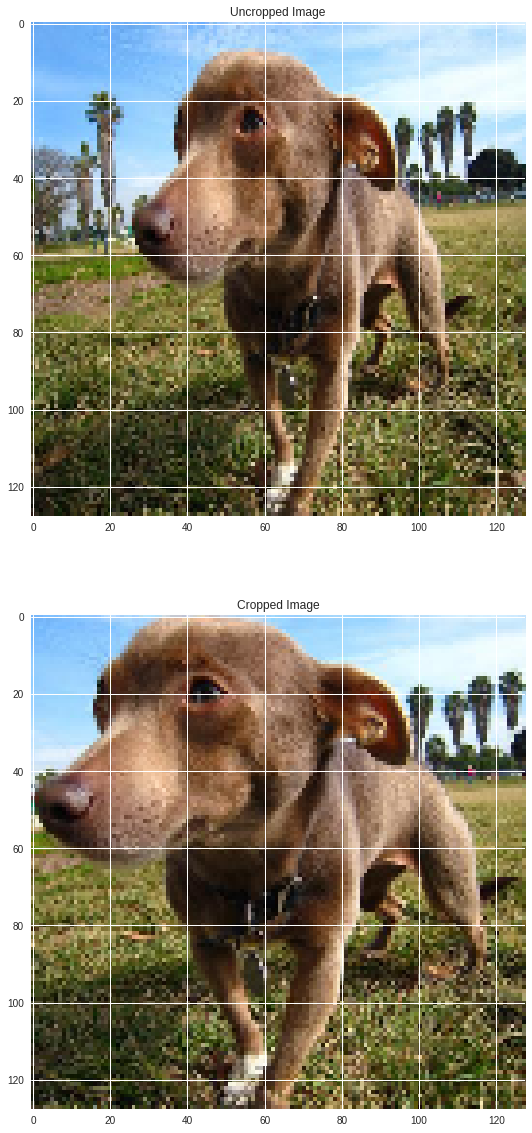

In [0]:
#Confirm that cropping has worked
fig, axes = plt.subplots(2,1, figsize=(20,20))
ax = axes.flatten()
counter = 0

ax[0].imshow(cv2.cvtColor(X_train_norm[25], cv2.COLOR_BGR2RGB))
ax[0].set_title("Uncropped Image")
ax[1].imshow(X_train_cropped[25])
ax[1].set_title("Cropped Image")


In [0]:
X_train_cropped[0].shape

(128, 128, 3)

In [0]:
#For some strange reason image index 7904 has 200+ channels. This was the cause of an error
#which prevented as from RGB coding CV2 data and threw an error in the next block of code.  Took 1 
#whole day to discover. We are declaring this image cursed. 
[(index, value.shape[2]) for index, value in enumerate(X_train_cropped) if value.shape[2] != 3]


[(7904, 213)]

In [0]:
abberant_x = X_train_cropped.pop(7904)
abberant_y = y_train_cropped.pop(7904)

In [0]:
# We divide training data by 255 to normalize the image data
#https://stackoverflow.com/questions/20486700/why-we-always-divide-rgb-values-by-255

X_train_cropped = np.array(X_train_cropped, np.float32) / 255.
y_train_cropped = np.array(y_train_cropped, np.uint8)

# The X data now consists of 12,000 images 
# that are 128 pixels by 128 pixels, and 3 channels
display(X_train_cropped.shape)

# The y data consists of 12,000 images of 120 distinct breeds
display(y_train_cropped.shape)

(11999, 128, 128, 3)

(11999, 120)

In [0]:
#Save unsplit copies for future reference
X_train_cropped_norm = X_train_cropped
y_train_cropped_norm = y_train_cropped

In [0]:
#Now we create the validation set by sampling from the training set 30% of values
X_train_cropped, X_validation_cropped, y_train_cropped, y_validation_cropped = train_test_split(X_train_cropped, 
                                                                y_train_cropped, 
                                                                test_size=0.3, 
                                                                random_state=42)

## 11. XCeption Network with Cropped Images

In [0]:
# fits the model on batches with real-time data augmentation:
from keras.preprocessing.image import ImageDataGenerator

# Let's go wild with data augmentation. 
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

# You don't do data augmentation on validation
validation_datagen = ImageDataGenerator()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_datagen.fit(X_train_cropped)
validation_datagen.fit(X_validation_cropped)


callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='weights_xception_augmented_cropped_best.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_acc')]

epochs = 20
batch_size = 32

history_augmented = model.fit_generator(train_datagen.flow(X_train_cropped, y_train_cropped),
                    epochs=epochs,
                    steps_per_epoch= X_train_cropped.shape[0] / batch_size,
                    validation_steps=X_validation_cropped.shape[0] / batch_size,
                    validation_data=validation_datagen.flow(X_validation_cropped, y_validation_cropped),
                    callbacks = callbacks_list)

Epoch 1/20
263/262 [==============================] - 78s 295ms/step - loss: 4.9497 - acc: 0.0887 - val_loss: 5.7813 - val_acc: 0.3256

Epoch 00001: val_acc improved from -inf to 0.32556, saving model to weights_xception_augmented_cropped_best.hdf5
Epoch 2/20
263/262 [==============================] - 67s 255ms/step - loss: 4.2932 - acc: 0.1610 - val_loss: 5.3722 - val_acc: 0.3747

Epoch 00002: val_acc improved from 0.32556 to 0.37472, saving model to weights_xception_augmented_cropped_best.hdf5
Epoch 3/20
263/262 [==============================] - 67s 255ms/step - loss: 4.0866 - acc: 0.1862 - val_loss: 5.2725 - val_acc: 0.3936

Epoch 00003: val_acc improved from 0.37472 to 0.39361, saving model to weights_xception_augmented_cropped_best.hdf5
Epoch 4/20
263/262 [==============================] - 67s 255ms/step - loss: 3.9429 - acc: 0.1968 - val_loss: 5.2033 - val_acc: 0.4078

Epoch 00004: val_acc improved from 0.39361 to 0.40778, saving model to weights_xception_augmented_cropped_best.

In [0]:
#save model weights
files.download('weights_xception_augmented_cropped_best.hdf5')

In [0]:
#load saved model weights for when kernel dies
model_weight = drive.CreateFile({'id':'1V7KIsPy9zhbVytQYyq1HFdtt2BAopyIn'})
model_weight.GetContentFile('weights_xception_augmented_cropped_best.hdf5')

In [0]:
#model.load_weights('weights_xception_augmented_cropped_best.hdf5')

AttributeError: ignored

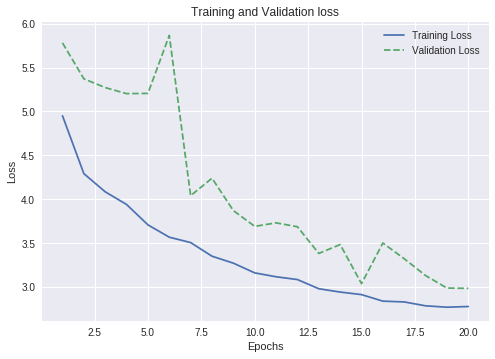

In [0]:
loss = history_augmented.history['loss']
val_loss = history_augmented.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,  label='Training Loss')
plt.plot(epochs, val_loss, '--',  label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

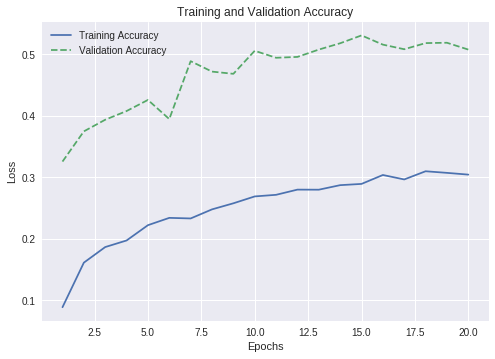

In [0]:
acc = history_augmented.history['acc']
val_acc = history_augmented.history['val_acc']
plt.plot(epochs, acc,  label='Training Accuracy')
plt.plot(epochs, val_acc, '--',  label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Comments:** 

* We see that this model achieved an impressive 53.08% accuracy when combined with cropped images and data augmentation.

* One might wonder why the validation accuracy is consistently higher than the training accuracy.  The reason is because the training model includes multiple dropout layers, which are activated only when training but deactivated when evaluating on the validation set.  This results in a smoother function when testing on the validation set. 




## 12. Error Analysis

In the following section we will perform error analysis on the best XCeption model found in the previous section. This includes a confusion matrix to see the prediction space, which enable us to evaluate and compare the model's ability to classify specific breeds within the dataset. This will show us outliers and breeds that the model has difficulty classifying. 

In [0]:
# Creates a set of test dummies
test_dummies = pd.get_dummies(test_df.Label)

# Converts above to a numpy array
test_labels_one_hot = np.asarray(test_dummies)

In [0]:
#generates the test dataset

%time

# Let's crop all the images 
X_test_cropped = []
y_test_cropped = []

# Set pixel dimensions to 128 x 128 
# We can experiment with other dimensions
im_size = 128

# Iterate over all values, resize images, append appropriate y values
for index, value in tqdm(test_df.iterrows()):
  
    #we use cv2 instead of imageio because resizing is faster within cv2
    img = imageio.imread("Images/" + test_df.iloc[index].File)
    
    #generate a bounding box around each image
    x_min, y_min, box_width, box_height = [int(value) for value in test_df['bounding_box'].iloc[index]]
   

    #generate a cropped version of the image
    crop_img = img[y_min:(y_min+box_height), x_min:(x_min+box_width)]
    
    # resize the image
    crop_img = cv2.resize(crop_img, (im_size, im_size))

    #converts bgr to rgb 
    #crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)

    X_test_cropped.append(crop_img)
    y_test_cropped.append(test_labels_one_hot[index])

0it [00:00, ?it/s]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


8580it [00:39, 216.65it/s]


In [0]:
# We divide training data by 255 to normalize the image data
#https://stackoverflow.com/questions/20486700/why-we-always-divide-rgb-values-by-255

X_test_cropped = np.array(X_test_cropped, np.float32) / 255.
y_test_cropped = np.array(y_test_cropped, np.uint8)

# The X data now consists of 12,000 images 
# that are 128 pixels by 128 pixels, and 3 channels
display(X_test_cropped.shape)

# The y data consists of 12,000 images of 120 distinct breeds
display(y_test_cropped.shape)

# Save this for comparison with cropped images later
X_test_cropped_norm = X_test_cropped

(8580, 128, 128, 3)

(8580, 120)

In [0]:
#load weights into model (remember to run XCeption model before doing this, 
# in order to define the model architecture, on which to load the weights)
model.load_weights('weights_xception_augmented_cropped_best.hdf5')

# evaluate the model
scores = model.evaluate(X_test_cropped, y_test_cropped, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8580/8580 [==============================] - 35s 4ms/step
acc: 53.73%


**Comment:**

Incredible!  Our model achieves an amazing 53.73% accuracy on our test set, blowing the baseline model and previous established performances out of the water.  

In [0]:
# creating list of predicted labels
y_pred = model.predict(X_test_cropped) 
y_pred_labels = np.argmax(y_pred, axis=1) 

In [0]:
# create breeds list from train data
breeds = np.unique(breed_list_train)

In [0]:
# creating confusion matrix from predicted labels vs. actual labels
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true=y_test_cropped.argmax(axis=1), y_pred=y_pred_labels) 

Now having produced two columns above, consisting of predicted and actual breed classifications, we can proceed to list the most misclassified pairs from the confusion matrix above. The bar graph below shows breed misclassification combinations in decending order of the numbers of misclassifications. It clearly showcases which breeds our final model had most difficulty distingguishing from each other. It also informs us on the classes which could be important to augment this dataset with. For example by using ImageDataGenerator to add more examples of these breeds or by introducting new examples of these breeds into the dataset, in an attempt to decrease the classification error between these "hard to classify" breeds.

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


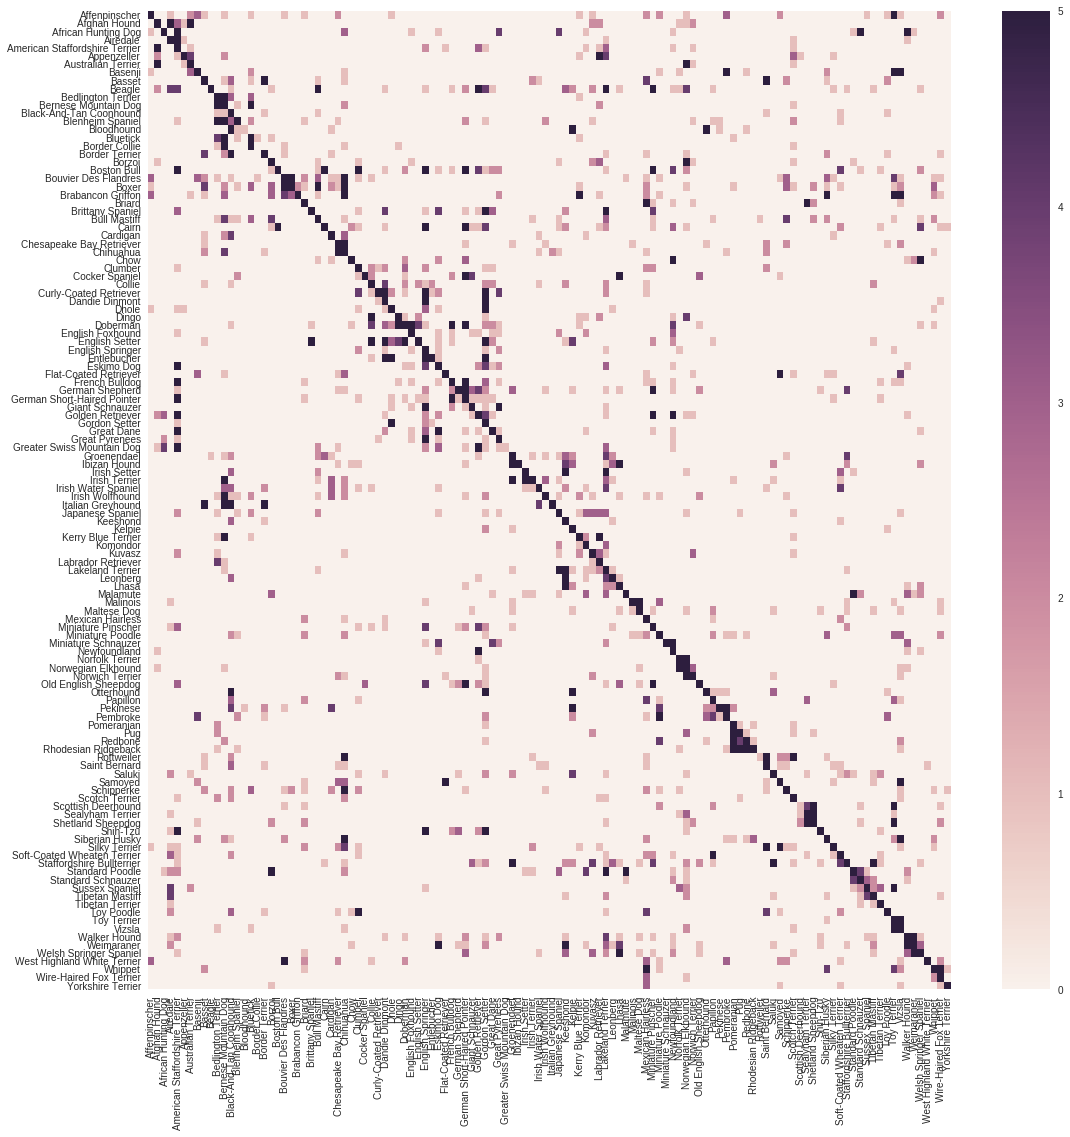

In [0]:
# plotting confusion matrix
fig, ax = plt.subplots(figsize=(18, 18))
_ = sns.heatmap(confusion_mat, ax=ax, yticklabels=breeds, xticklabels=breeds, robust=True)

**Comment**:

The confusion matrix above gives us a sense of the breeds our model successfully classfies and examples it struggles to classify. Since the dataset consists of 120 different breeds, it is however quite difficult to quantify from the plot which specific breed combinations the model has more difficulty distinguishing from others. It is however a powerful result to see the dark diagonal line, showcasing correct classification, which for this final model is more than half of the examples in the test set.

In in order to present some of the most relevant data from the confusion matrix above in a more concise format, the predicted and actual one hot labels will be converted back to dataframes consisting of predicted breed names and actual breed names.

In [0]:
# convert predicted and actual arrays to dataframes and plot the top 15 misclassification pairs
predicted_df = pd.DataFrame(y_pred_labels)
actual_df = pd.DataFrame(y_test_cropped.argmax(axis=1))

combined_df = pd.concat([predicted_df, actual_df], axis=1)
combined_df.columns = ['predicted_df', 'actual_df']

combined_df.head()

,predicted_df,actual_df
0,0,0
1,0,0
2,6,0
3,80,0
4,0,0


In [0]:
# convert to dataframes of breed names
breed_comb_df = pd.concat([pd.DataFrame(breeds[predicted_df]), pd.DataFrame(breeds[actual_df])], axis=1)

In [0]:
# rename columns
breed_comb_df.columns = ['predicted_df', 'actual_df']
breed_comb_df['count'] = 1
breed_comb_df.head()

,predicted_df,actual_df,count
0,Affenpinscher,Affenpinscher,1
1,Affenpinscher,Affenpinscher,1
2,Australian Terrier,Affenpinscher,1
3,Norwegian Elkhound,Affenpinscher,1
4,Affenpinscher,Affenpinscher,1


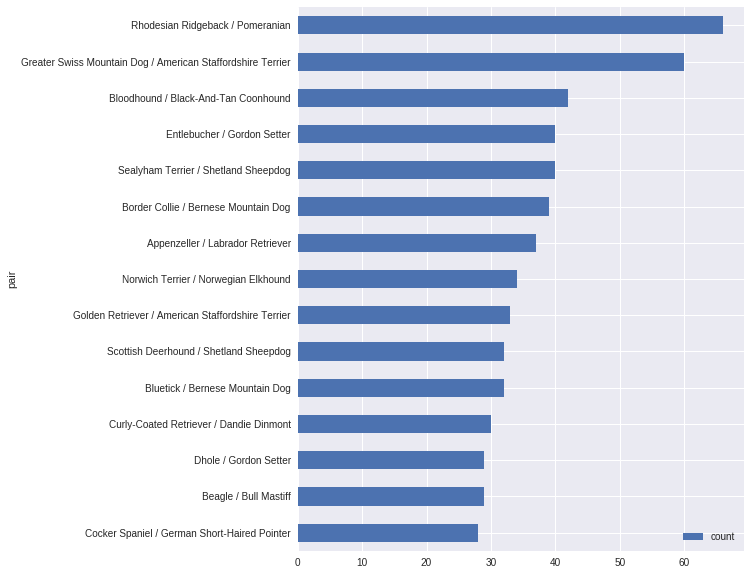

In [0]:
# misclassification error
error_df = breed_comb_df[breed_comb_df['actual_df'] != breed_comb_df['predicted_df']].groupby(['actual_df', 'predicted_df']).sum().sort_values(['count'], ascending=False).reset_index()
error_df['pair'] = error_df['actual_df'] + ' / ' + error_df['predicted_df']
error_df = error_df[['pair', 'count']].take(range(14,-1,-1))

error_df.plot.barh(figsize=(8, 10), x=error_df['pair'])

In [0]:
misclass_df

,pair,count
0,Rhodesian Ridgeback / Pomeranian,66
1,Greater Swiss Mountain Dog / American Stafford...,60
2,Bloodhound / Black-And-Tan Coonhound,42
3,Entlebucher / Gordon Setter,40
4,Sealyham Terrier / Shetland Sheepdog,40
5,Border Collie / Bernese Mountain Dog,39
6,Appenzeller / Labrador Retriever,37
7,Norwich Terrier / Norwegian Elkhound,34
8,Golden Retriever / American Staffordshire Terrier,33
9,Scottish Deerhound / Shetland Sheepdog,32


While some of these errors are hard to make sense of (e.g. a Rhodesian Ridgeback and a Pomeranian do not look similar), others are perfectly sensible.  Take, for example, a Border Collie and a Bernese Mountain Dog, which our model misclassified 39 times.

**This a Border Collie:**


![alt text](http://s6004.pcdn.co/wp-content/uploads/2015/04/e71b83c52a63cf8f2585122cb5cebc3e.jpg)

**This is a Bernese Mountain Dog:**


![alt text](https://www.rover.com/blog/wp-content/uploads/2018/02/bernese.jpg)


Meanwhile, the most misclassified pair of a Rhodesian Ridgeback and Pomeranian seem to share the same color scheme, even if they look quite dissimilar by a human's eyes:

![alt text](https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12225627/Pomeranian-On-White-01.jpg)


![alt text](https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12225044/Rhodesian-Ridgeback-On-White-03-400x267.jpg)


What is perhaps most interesting is actually how well our model does at correctly distinguishing between two breeds of dogs which humans would reliably mistake.  For example, our model never mis-classified a Pembroke Corgi and a Cardigan Terrier.  

We present images of both dogs in the same image to show how difficult this classification is:

![alt text](https://i.pinimg.com/originals/8a/8a/f4/8a8af49b07e317538e5ee3bba0df8e20.jpg)

![alt text](http://corgiguide.com/wp-content/uploads/2014/08/Kelsey_n_Penny.jpg)

The key distinction between these two breeds is that Cardigan's have larger ears and long, fluffy tail, while Pembroke's have medium-sized ears and docked tails.  The fact that our classifier was able to reliably distinguish these breeds, but failed at more obvious comparisons (like Rhodesian Ridgeback / Pomeranian), shows how opaque these techniques can be, and how imprecisely they emulate human vision / cognition, even while out-performing human experts at dog breed identification!. 

## 13. Validation Accuracy Across Models




In [0]:
# Collecting validation accuracy across models
val_data = {'Validation Accuracy': [3.75, 13.25, 18.83, 13.28, 10.11, 10.754, 22.806, 17.667, 53.083]}
val_score_df = pd.DataFrame(data=val_data)
val_score_df.index = ['Baseline - Fully Connected Neural Net','Custom-Architecture CNN (No Dropout)', \
                      'Custom-Architecture CNN (With Dropout)', 'Fine Tuning VGG19', \
                      'VGG19 with Data Augmentation and Drop-Out Layers',\
                      'Inception v3 Neural Net','XCeption Model',\
                      'XCeption Model with Data Augmentation',\
                      'XCeption Model with Data Augmentation and Cropped Images']
val_score_df

,Validation Accuracy
Baseline - Fully Connected Neural Net,3.750
Custom-Architecture CNN (No Dropout),13.250
Custom-Architecture CNN (With Dropout),18.830
Fine Tuning VGG19,13.280
VGG19 with Data Augmentation and Drop-Out Layers,10.110
Inception v3 Neural Net,10.754
XCeption Model,22.806
XCeption Model with Data Augmentation,17.667
XCeption Model with Data Augmentation and Cropped Images,53.083
